In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:19 - loss: 0.2048 - STD: 1.1327e-04 - MAE: 0.4414

 4/64 [>.............................] - ETA: 1s - loss: 0.0687 - STD: 3.1233e-04 - MAE: 0.2010  

 5/64 [=>............................] - ETA: 1s - loss: 0.0592 - STD: 2.7709e-04 - MAE: 0.1829

 6/64 [=>............................] - ETA: 2s - loss: 0.0537 - STD: 2.4396e-04 - MAE: 0.1737

 7/64 [==>...........................] - ETA: 2s - loss: 0.0500 - STD: 2.1593e-04 - MAE: 0.1684

 8/64 [==>...........................] - ETA: 2s - loss: 0.0476 - STD: 1.9275e-04 - MAE: 0.1652

 9/64 [===>..........................] - ETA: 2s - loss: 0.0458 - STD: 1.7351e-04 - MAE: 0.1631

10/64 [===>..........................] - ETA: 2s - loss: 0.0443 - STD: 1.5742e-04 - MAE: 0.1616

11/64 [====>.........................] - ETA: 2s - loss: 0.0432 - STD: 1.4389e-04 - MAE: 0.1604

12/64 [====>.........................] - ETA: 2s - loss: 0.0422 - STD: 1.3233e-04 - MAE: 0.1594

13/64 [=====>........................] - ETA: 2s - loss: 0.0414 - STD: 1.2248e-04 - MAE: 0.1584

14/64 [=====>........................] - ETA: 2s - loss: 0.0406 - STD: 1.1409e-04 - MAE: 0.1575

15/64 [======>.......................] - ETA: 2s - loss: 0.0400 - STD: 1.0691e-04 - MAE: 0.1566

16/64 [======>.......................] - ETA: 2s - loss: 0.0393 - STD: 1.0072e-04 - MAE: 0.1555

17/64 [======>.......................] - ETA: 2s - loss: 0.0386 - STD: 9.5363e-05 - MAE: 0.1544

18/64 [=======>......................] - ETA: 2s - loss: 0.0380 - STD: 9.0706e-05 - MAE: 0.1531

19/64 [=======>......................] - ETA: 2s - loss: 0.0373 - STD: 8.6672e-05 - MAE: 0.1517

20/64 [========>.....................] - ETA: 2s - loss: 0.0366 - STD: 8.3067e-05 - MAE: 0.1501

21/64 [========>.....................] - ETA: 2s - loss: 0.0359 - STD: 7.9980e-05 - MAE: 0.1483

22/64 [=========>....................] - ETA: 2s - loss: 0.0351 - STD: 7.7301e-05 - MAE: 0.1463

23/64 [=========>....................] - ETA: 2s - loss: 0.0343 - STD: 7.5016e-05 - MAE: 0.1441

24/64 [==========>...................] - ETA: 2s - loss: 0.0335 - STD: 7.3104e-05 - MAE: 0.1418

25/64 [==========>...................] - ETA: 2s - loss: 0.0327 - STD: 7.1529e-05 - MAE: 0.1393

26/64 [===========>..................] - ETA: 2s - loss: 0.0319 - STD: 7.0198e-05 - MAE: 0.1369

27/64 [===========>..................] - ETA: 2s - loss: 0.0311 - STD: 6.9128e-05 - MAE: 0.1347

28/64 [============>.................] - ETA: 2s - loss: 0.0303 - STD: 6.8248e-05 - MAE: 0.1327

29/64 [============>.................] - ETA: 1s - loss: 0.0296 - STD: 6.7424e-05 - MAE: 0.1309

30/64 [=============>................] - ETA: 1s - loss: 0.0290 - STD: 6.6719e-05 - MAE: 0.1295

31/64 [=============>................] - ETA: 1s - loss: 0.0285 - STD: 6.6078e-05 - MAE: 0.1284

32/64 [==============>...............] - ETA: 1s - loss: 0.0280 - STD: 6.5357e-05 - MAE: 0.1274

33/64 [==============>...............] - ETA: 1s - loss: 0.0275 - STD: 6.4578e-05 - MAE: 0.1266

34/64 [==============>...............] - ETA: 1s - loss: 0.0271 - STD: 6.3733e-05 - MAE: 0.1257

35/64 [===============>..............] - ETA: 1s - loss: 0.0267 - STD: 6.2808e-05 - MAE: 0.1248

36/64 [===============>..............] - ETA: 1s - loss: 0.0263 - STD: 6.1805e-05 - MAE: 0.1238

37/64 [================>.............] - ETA: 1s - loss: 0.0259 - STD: 6.0765e-05 - MAE: 0.1228

38/64 [================>.............] - ETA: 1s - loss: 0.0254 - STD: 5.9724e-05 - MAE: 0.1218

39/64 [=================>............] - ETA: 1s - loss: 0.0251 - STD: 5.8691e-05 - MAE: 0.1207

40/64 [=================>............] - ETA: 1s - loss: 0.0250 - STD: 5.7590e-05 - MAE: 0.1196

44/64 [===================>..........] - ETA: 1s - loss: 0.0236 - STD: 5.3480e-05 - MAE: 0.1157

45/64 [====================>.........] - ETA: 1s - loss: 0.0233 - STD: 5.2544e-05 - MAE: 0.1148

46/64 [====================>.........] - ETA: 1s - loss: 0.0231 - STD: 5.1654e-05 - MAE: 0.1139

47/64 [=====================>........] - ETA: 1s - loss: 0.0228 - STD: 5.0801e-05 - MAE: 0.1132

48/64 [=====================>........] - ETA: 1s - loss: 0.0225 - STD: 4.9996e-05 - MAE: 0.1124

49/64 [=====================>........] - ETA: 0s - loss: 0.0223 - STD: 4.9225e-05 - MAE: 0.1116

50/64 [======================>.......] - ETA: 0s - loss: 0.0220 - STD: 4.8470e-05 - MAE: 0.1109

51/64 [======================>.......] - ETA: 0s - loss: 0.0218 - STD: 4.7771e-05 - MAE: 0.1103

52/64 [=======================>......] - ETA: 0s - loss: 0.0216 - STD: 4.7105e-05 - MAE: 0.1096

53/64 [=======================>......] - ETA: 0s - loss: 0.0213 - STD: 4.6479e-05 - MAE: 0.1090

54/64 [========================>.....] - ETA: 0s - loss: 0.0211 - STD: 4.5881e-05 - MAE: 0.1084

55/64 [========================>.....] - ETA: 0s - loss: 0.0209 - STD: 4.5315e-05 - MAE: 0.1079

56/64 [=========================>....] - ETA: 0s - loss: 0.0207 - STD: 4.4778e-05 - MAE: 0.1074

57/64 [=========================>....] - ETA: 0s - loss: 0.0205 - STD: 4.4246e-05 - MAE: 0.1069

58/64 [==========================>...] - ETA: 0s - loss: 0.0204 - STD: 4.3745e-05 - MAE: 0.1065

59/64 [==========================>...] - ETA: 0s - loss: 0.0202 - STD: 4.3268e-05 - MAE: 0.1061

60/64 [===========================>..] - ETA: 0s - loss: 0.0200 - STD: 4.2798e-05 - MAE: 0.1057

61/64 [===========================>..] - ETA: 0s - loss: 0.0198 - STD: 4.2340e-05 - MAE: 0.1052

62/64 [============================>.] - ETA: 0s - loss: 0.0197 - STD: 4.1915e-05 - MAE: 0.1048

63/64 [============================>.] - ETA: 0s - loss: 0.0195 - STD: 4.1476e-05 - MAE: 0.1044

64/64 [==============================] - ETA: 0s - loss: 0.0194 - STD: 4.1072e-05 - MAE: 0.1040

64/64 [==============================] - 6s 72ms/step - loss: 0.0194 - STD: 4.1072e-05 - MAE: 0.1040 - val_loss: 0.0094 - val_STD: 1.2274e-05 - val_MAE: 0.0768


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0101 - STD: 1.4378e-05 - MAE: 0.0791

 2/64 [..............................] - ETA: 3s - loss: 0.0100 - STD: 1.4371e-05 - MAE: 0.0783

 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.4236e-05 - MAE: 0.0780

 4/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 1.4450e-05 - MAE: 0.0779

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.4256e-05 - MAE: 0.0776

 6/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 1.4419e-05 - MAE: 0.0776

 7/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 1.4478e-05 - MAE: 0.0775

 8/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 1.4344e-05 - MAE: 0.0774

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.4332e-05 - MAE: 0.0773

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.4600e-05 - MAE: 0.0772

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.4656e-05 - MAE: 0.0772

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.4640e-05 - MAE: 0.0772

13/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 1.4812e-05 - MAE: 0.0773

14/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 1.4979e-05 - MAE: 0.0774

15/64 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 1.4965e-05 - MAE: 0.0775

16/64 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 1.5054e-05 - MAE: 0.0775

17/64 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 1.5229e-05 - MAE: 0.0777

18/64 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 1.5345e-05 - MAE: 0.0777

19/64 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 1.5455e-05 - MAE: 0.0778

20/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 1.5566e-05 - MAE: 0.0778

21/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 1.5714e-05 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 1.5822e-05 - MAE: 0.0779

23/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 1.5919e-05 - MAE: 0.0779

24/64 [==========>...................] - ETA: 2s - loss: 0.0100 - STD: 1.6030e-05 - MAE: 0.0779

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.6205e-05 - MAE: 0.0779

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.6360e-05 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.6460e-05 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.6540e-05 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.6605e-05 - MAE: 0.0778

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 1.6686e-05 - MAE: 0.0778

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 1.6774e-05 - MAE: 0.0777

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.6859e-05 - MAE: 0.0777

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.6961e-05 - MAE: 0.0777

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.7072e-05 - MAE: 0.0777

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.7219e-05 - MAE: 0.0777

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.7370e-05 - MAE: 0.0777

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.7499e-05 - MAE: 0.0778

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.7647e-05 - MAE: 0.0778

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.7788e-05 - MAE: 0.0778

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.7910e-05 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.8057e-05 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.8199e-05 - MAE: 0.0778

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.8328e-05 - MAE: 0.0778

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.8621e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.8791e-05 - MAE: 0.0778

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.8981e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.9114e-05 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.9256e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.9414e-05 - MAE: 0.0777

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.9575e-05 - MAE: 0.0777

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.9723e-05 - MAE: 0.0777

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.9861e-05 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.0013e-05 - MAE: 0.0777

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.0202e-05 - MAE: 0.0777

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.0388e-05 - MAE: 0.0777

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.0596e-05 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.0801e-05 - MAE: 0.0777

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.0994e-05 - MAE: 0.0777

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.1183e-05 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.1362e-05 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.1552e-05 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.1748e-05 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 2.1954e-05 - MAE: 0.0778

64/64 [==============================] - 4s 60ms/step - loss: 0.0099 - STD: 2.1954e-05 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 2.6659e-05 - val_MAE: 0.0767


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0100 - STD: 3.5306e-05 - MAE: 0.0785

 2/64 [..............................] - ETA: 3s - loss: 0.0101 - STD: 3.5918e-05 - MAE: 0.0787

 3/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 3.6659e-05 - MAE: 0.0785

 4/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 3.7185e-05 - MAE: 0.0783

 5/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 3.7584e-05 - MAE: 0.0784

 6/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 3.7963e-05 - MAE: 0.0783

 7/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 3.8359e-05 - MAE: 0.0781

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 3.8754e-05 - MAE: 0.0781

 9/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 3.9017e-05 - MAE: 0.0782

10/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 3.9292e-05 - MAE: 0.0781

11/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 3.9619e-05 - MAE: 0.0781

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.9901e-05 - MAE: 0.0780

13/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 4.0272e-05 - MAE: 0.0781

14/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 4.0640e-05 - MAE: 0.0780

15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 4.1001e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 4.1363e-05 - MAE: 0.0779

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 4.1674e-05 - MAE: 0.0779

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 4.1975e-05 - MAE: 0.0780

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 4.2273e-05 - MAE: 0.0780

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 4.2610e-05 - MAE: 0.0780

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 4.2927e-05 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 4.3291e-05 - MAE: 0.0779

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 4.3694e-05 - MAE: 0.0779

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 4.4096e-05 - MAE: 0.0780

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 4.4480e-05 - MAE: 0.0779

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.4861e-05 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.5256e-05 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.5685e-05 - MAE: 0.0780

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.6123e-05 - MAE: 0.0780

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.6552e-05 - MAE: 0.0780

31/64 [=============>................] - ETA: 1s - loss: 0.0100 - STD: 4.7013e-05 - MAE: 0.0780

32/64 [==============>...............] - ETA: 1s - loss: 0.0100 - STD: 4.7458e-05 - MAE: 0.0780

33/64 [==============>...............] - ETA: 1s - loss: 0.0100 - STD: 4.7909e-05 - MAE: 0.0780

34/64 [==============>...............] - ETA: 1s - loss: 0.0100 - STD: 4.8361e-05 - MAE: 0.0781

35/64 [===============>..............] - ETA: 1s - loss: 0.0100 - STD: 4.8837e-05 - MAE: 0.0781

36/64 [===============>..............] - ETA: 1s - loss: 0.0100 - STD: 4.9335e-05 - MAE: 0.0781

37/64 [================>.............] - ETA: 1s - loss: 0.0100 - STD: 4.9837e-05 - MAE: 0.0781

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.0346e-05 - MAE: 0.0781

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 5.0853e-05 - MAE: 0.0781

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 5.1354e-05 - MAE: 0.0780

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.1904e-05 - MAE: 0.0780

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.2501e-05 - MAE: 0.0780

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.3108e-05 - MAE: 0.0780

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.3717e-05 - MAE: 0.0780

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.4328e-05 - MAE: 0.0780

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.4930e-05 - MAE: 0.0780

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.5558e-05 - MAE: 0.0780

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 5.6185e-05 - MAE: 0.0780

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.7497e-05 - MAE: 0.0780

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.8160e-05 - MAE: 0.0780

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.8867e-05 - MAE: 0.0780

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.9594e-05 - MAE: 0.0780

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 6.0356e-05 - MAE: 0.0780

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 6.1137e-05 - MAE: 0.0780

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 6.1929e-05 - MAE: 0.0780

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 6.2754e-05 - MAE: 0.0780

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.3588e-05 - MAE: 0.0780

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.4403e-05 - MAE: 0.0780

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 6.5245e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 6.6141e-05 - MAE: 0.0780

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 6.7042e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 6.7966e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 6.8902e-05 - MAE: 0.0779

64/64 [==============================] - 4s 61ms/step - loss: 0.0099 - STD: 6.8902e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 9.4638e-05 - val_MAE: 0.0761


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0100 - STD: 1.2961e-04 - MAE: 0.0777

 2/64 [..............................] - ETA: 3s - loss: 0.0101 - STD: 1.3192e-04 - MAE: 0.0779

 3/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 1.3368e-04 - MAE: 0.0778

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.3539e-04 - MAE: 0.0776

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.3759e-04 - MAE: 0.0777

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.3958e-04 - MAE: 0.0776

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.4152e-04 - MAE: 0.0776

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.4369e-04 - MAE: 0.0775

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.4583e-04 - MAE: 0.0775

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.4818e-04 - MAE: 0.0776

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 1.5047e-04 - MAE: 0.0775

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 1.5262e-04 - MAE: 0.0775

13/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 1.5490e-04 - MAE: 0.0775

14/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 1.5723e-04 - MAE: 0.0775

15/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 1.5965e-04 - MAE: 0.0776

16/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 1.6207e-04 - MAE: 0.0775

17/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 1.6451e-04 - MAE: 0.0775

18/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 1.6723e-04 - MAE: 0.0775

19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 1.6992e-04 - MAE: 0.0775

20/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 1.7273e-04 - MAE: 0.0775

21/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 1.7558e-04 - MAE: 0.0775

22/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 1.7858e-04 - MAE: 0.0774

23/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 1.8174e-04 - MAE: 0.0775

24/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 1.8492e-04 - MAE: 0.0775

25/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 1.8832e-04 - MAE: 0.0776

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.9178e-04 - MAE: 0.0776

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.9901e-04 - MAE: 0.0777

29/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 2.0267e-04 - MAE: 0.0777

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 2.0642e-04 - MAE: 0.0777

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 2.1031e-04 - MAE: 0.0777

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.1430e-04 - MAE: 0.0777

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.1854e-04 - MAE: 0.0777

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.2293e-04 - MAE: 0.0777

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.2743e-04 - MAE: 0.0777

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.3192e-04 - MAE: 0.0776

37/64 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 2.3653e-04 - MAE: 0.0776

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.4138e-04 - MAE: 0.0776

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.4630e-04 - MAE: 0.0776

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.5140e-04 - MAE: 0.0776

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.5677e-04 - MAE: 0.0776

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.6230e-04 - MAE: 0.0776

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.6806e-04 - MAE: 0.0777

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.7398e-04 - MAE: 0.0777

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.8010e-04 - MAE: 0.0777

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.8633e-04 - MAE: 0.0777

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.9282e-04 - MAE: 0.0777

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.9961e-04 - MAE: 0.0777

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.0664e-04 - MAE: 0.0777

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.1381e-04 - MAE: 0.0777

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.2130e-04 - MAE: 0.0777

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.2910e-04 - MAE: 0.0777

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.3712e-04 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.4543e-04 - MAE: 0.0777

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.5410e-04 - MAE: 0.0777

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.6324e-04 - MAE: 0.0777

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.7276e-04 - MAE: 0.0777

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.8257e-04 - MAE: 0.0777

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.9277e-04 - MAE: 0.0777

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.0324e-04 - MAE: 0.0777

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.1430e-04 - MAE: 0.0777

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.2572e-04 - MAE: 0.0777

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.3784e-04 - MAE: 0.0777

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 4.5031e-04 - MAE: 0.0777

64/64 [==============================] - 4s 59ms/step - loss: 0.0099 - STD: 4.5031e-04 - MAE: 0.0777 - val_loss: 0.0093 - val_STD: 9.2493e-04 - val_MAE: 0.0760


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0097 - STD: 0.0013 - MAE: 0.0770

 2/64 [..............................] - ETA: 3s - loss: 0.0097 - STD: 0.0013 - MAE: 0.0773

 3/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0773

 4/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0014 - MAE: 0.0771

 5/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0014 - MAE: 0.0771

 6/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0771

 7/64 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0773

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0772

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0773

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0774

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0774

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0774

13/64 [=====>........................] - ETA: 3s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0774

14/64 [=====>........................] - ETA: 2s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773

15/64 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0774

16/64 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0773

17/64 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0774

18/64 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0774

19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0021 - MAE: 0.0774

20/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 0.0022 - MAE: 0.0774

21/64 [========>.....................] - ETA: 2s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0774

22/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0774

23/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0773

24/64 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0773

25/64 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0773

26/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0772

27/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0772

28/64 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0772

29/64 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0771

30/64 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0771

31/64 [=============>................] - ETA: 1s - loss: 0.0096 - STD: 0.0031 - MAE: 0.0770

32/64 [==============>...............] - ETA: 1s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0770

33/64 [==============>...............] - ETA: 1s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0770

35/64 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0769

36/64 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0769

37/64 [================>.............] - ETA: 1s - loss: 0.0096 - STD: 0.0038 - MAE: 0.0768

38/64 [================>.............] - ETA: 1s - loss: 0.0096 - STD: 0.0039 - MAE: 0.0768

39/64 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0041 - MAE: 0.0767

40/64 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0042 - MAE: 0.0767

41/64 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0044 - MAE: 0.0767

42/64 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0046 - MAE: 0.0766

43/64 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.0047 - MAE: 0.0765

44/64 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.0049 - MAE: 0.0765

45/64 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.0051 - MAE: 0.0765

46/64 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.0053 - MAE: 0.0764

47/64 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0054 - MAE: 0.0764

48/64 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0056 - MAE: 0.0763

49/64 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0058 - MAE: 0.0762

50/64 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0061 - MAE: 0.0762

51/64 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0063 - MAE: 0.0761

52/64 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0065 - MAE: 0.0760

53/64 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0067 - MAE: 0.0760

54/64 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.0070 - MAE: 0.0759

55/64 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0072 - MAE: 0.0758

56/64 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0074 - MAE: 0.0758

57/64 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0077 - MAE: 0.0757

58/64 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0079 - MAE: 0.0756

59/64 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0082 - MAE: 0.0756

60/64 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0085 - MAE: 0.0755

61/64 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0087 - MAE: 0.0755

62/64 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0090 - MAE: 0.0754

63/64 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0093 - MAE: 0.0753

64/64 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0096 - MAE: 0.0753

64/64 [==============================] - 4s 61ms/step - loss: 0.0092 - STD: 0.0096 - MAE: 0.0753 - val_loss: 0.0076 - val_STD: 0.0188 - val_MAE: 0.0691


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0081 - STD: 0.0281 - MAE: 0.0704

 2/64 [..............................] - ETA: 3s - loss: 0.0079 - STD: 0.0284 - MAE: 0.0701

 3/64 [>.............................] - ETA: 3s - loss: 0.0081 - STD: 0.0289 - MAE: 0.0705

 4/64 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.0293 - MAE: 0.0703

 5/64 [=>............................] - ETA: 3s - loss: 0.0080 - STD: 0.0297 - MAE: 0.0701

 6/64 [=>............................] - ETA: 3s - loss: 0.0080 - STD: 0.0301 - MAE: 0.0700

 7/64 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.0305 - MAE: 0.0698

 8/64 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.0309 - MAE: 0.0698

 9/64 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.0313 - MAE: 0.0697

10/64 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.0316 - MAE: 0.0696

11/64 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.0320 - MAE: 0.0696

12/64 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.0323 - MAE: 0.0695

13/64 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.0326 - MAE: 0.0695

14/64 [=====>........................] - ETA: 2s - loss: 0.0079 - STD: 0.0329 - MAE: 0.0694

15/64 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.0332 - MAE: 0.0692

16/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0335 - MAE: 0.0691

17/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0337 - MAE: 0.0691

18/64 [=======>......................] - ETA: 2s - loss: 0.0078 - STD: 0.0340 - MAE: 0.0689

19/64 [=======>......................] - ETA: 2s - loss: 0.0078 - STD: 0.0342 - MAE: 0.0688

20/64 [========>.....................] - ETA: 2s - loss: 0.0078 - STD: 0.0344 - MAE: 0.0686

21/64 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.0347 - MAE: 0.0685

22/64 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0349 - MAE: 0.0685

23/64 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0351 - MAE: 0.0684

24/64 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.0354 - MAE: 0.0683

25/64 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.0356 - MAE: 0.0682

26/64 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0358 - MAE: 0.0681

27/64 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0360 - MAE: 0.0680

28/64 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.0363 - MAE: 0.0679

29/64 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.0365 - MAE: 0.0678

30/64 [=============>................] - ETA: 2s - loss: 0.0076 - STD: 0.0368 - MAE: 0.0677

31/64 [=============>................] - ETA: 2s - loss: 0.0076 - STD: 0.0370 - MAE: 0.0676

32/64 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0373 - MAE: 0.0675

33/64 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0375 - MAE: 0.0674

34/64 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0377 - MAE: 0.0673

35/64 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.0380 - MAE: 0.0673

36/64 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.0383 - MAE: 0.0671

37/64 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0386 - MAE: 0.0670

38/64 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0388 - MAE: 0.0669

39/64 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.0391 - MAE: 0.0668

40/64 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.0393 - MAE: 0.0667

41/64 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0396 - MAE: 0.0666

42/64 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0398 - MAE: 0.0665

43/64 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0401 - MAE: 0.0664

44/64 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0403 - MAE: 0.0662

45/64 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0406 - MAE: 0.0661

46/64 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0408 - MAE: 0.0660

47/64 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.0411 - MAE: 0.0659

48/64 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0414 - MAE: 0.0658

49/64 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0416 - MAE: 0.0656

50/64 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0418 - MAE: 0.0655

51/64 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0421 - MAE: 0.0654

52/64 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0423 - MAE: 0.0653

53/64 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0425 - MAE: 0.0652

54/64 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0428 - MAE: 0.0652

55/64 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0650

56/64 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0432 - MAE: 0.0649

57/64 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0434 - MAE: 0.0648

58/64 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0436 - MAE: 0.0647

59/64 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0438 - MAE: 0.0646

60/64 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0440 - MAE: 0.0645

62/64 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0445 - MAE: 0.0644

63/64 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0446 - MAE: 0.0643

64/64 [==============================] - ETA: 0s - loss: 0.0069 - STD: 0.0448 - MAE: 0.0642

64/64 [==============================] - 4s 65ms/step - loss: 0.0069 - STD: 0.0448 - MAE: 0.0642 - val_loss: 0.0052 - val_STD: 0.0536 - val_MAE: 0.0573


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0604 - MAE: 0.0599

 2/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0576 - MAE: 0.0587

 3/64 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.0581 - MAE: 0.0585

 4/64 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0592 - MAE: 0.0589

 5/64 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0584 - MAE: 0.0584

 6/64 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0586 - MAE: 0.0581

 7/64 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0592 - MAE: 0.0584

 8/64 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0589 - MAE: 0.0584

 9/64 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0590 - MAE: 0.0583

10/64 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0595 - MAE: 0.0586

11/64 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0593 - MAE: 0.0584

12/64 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0591 - MAE: 0.0583

13/64 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0594 - MAE: 0.0584

14/64 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0595 - MAE: 0.0584

15/64 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0593 - MAE: 0.0583

16/64 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0593 - MAE: 0.0583

17/64 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0583

18/64 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0583

19/64 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0593 - MAE: 0.0583

20/64 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0583

21/64 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0583

22/64 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0582

23/64 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0581

24/64 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0581

25/64 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0596 - MAE: 0.0581

26/64 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0596 - MAE: 0.0581

27/64 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0597 - MAE: 0.0580

28/64 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0580

29/64 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0580

30/64 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0579

31/64 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0579

32/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0579

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0579

34/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0579

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0579

36/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0579

37/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0578

38/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0578

39/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0578

40/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0578

41/64 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0578

42/64 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0578

44/64 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0578

45/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0601 - MAE: 0.0578

46/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0578

47/64 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0578

48/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0578

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0603 - MAE: 0.0577

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0604 - MAE: 0.0577

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0604 - MAE: 0.0577

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0577

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0576

54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0576

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0576

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0576

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0576

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0606 - MAE: 0.0576

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0576

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0575

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0575

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0575

63/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0608 - MAE: 0.0575

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0608 - MAE: 0.0575

64/64 [==============================] - 4s 63ms/step - loss: 0.0057 - STD: 0.0608 - MAE: 0.0575 - val_loss: 0.0047 - val_STD: 0.0550 - val_MAE: 0.0531


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0555

 2/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0560

 3/64 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0562

 4/64 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0563

 5/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0562

 6/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0562

 7/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0562

 8/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0562

 9/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0626 - MAE: 0.0560

10/64 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0560

11/64 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0561

13/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0561

14/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0561

15/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0561

16/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0560

17/64 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0560

18/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0560

19/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0560

20/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0559

21/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0560

22/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

23/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0560

24/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0560

25/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

26/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0560

27/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0560

28/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

29/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

30/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

31/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

32/64 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

33/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

34/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0560

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0559

36/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0560

37/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0560

38/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0560

39/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0560

40/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0560

41/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0560

42/64 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0559

43/64 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0559

44/64 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0559

45/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0559

46/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0559

47/64 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0559

48/64 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0558

49/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0558

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0558

51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0558

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0558

53/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0558

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0558

55/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0558

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0558

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0558

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0558

59/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0557

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0557

61/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0640 - MAE: 0.0557

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0557

63/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0557

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0557

64/64 [==============================] - 4s 67ms/step - loss: 0.0054 - STD: 0.0641 - MAE: 0.0557 - val_loss: 0.0045 - val_STD: 0.0578 - val_MAE: 0.0522


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0547

 2/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0547

 3/64 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0549

 4/64 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0550

 5/64 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0548

 6/64 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0548

 7/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0549

 8/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0549

 9/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0548

10/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0547

11/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0548

12/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0548

13/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0548

14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0549

15/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0549

16/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0549

17/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0549

18/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0549

19/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0549

20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0549

21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0548

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0549

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0549

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0548

30/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0548

31/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0548

32/64 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0548

33/64 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0548

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

40/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

41/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0547

43/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0547

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0547

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0547

46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0547

47/64 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0547

48/64 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0546

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0547

51/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0547

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0547

53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0548

54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0547

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0549

57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0549

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0548

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0548

63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0549

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0549

64/64 [==============================] - 4s 69ms/step - loss: 0.0053 - STD: 0.0656 - MAE: 0.0549 - val_loss: 0.0045 - val_STD: 0.0560 - val_MAE: 0.0508


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0535

 2/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0537

 3/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0542

 4/64 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0542

 5/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0540

 6/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0541

 7/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0542

 8/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0541

 9/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0541

10/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0542

11/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0540

12/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0539

13/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540

14/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0540

15/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0540

16/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0540

17/64 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0540

18/64 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0540

19/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

21/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0540

22/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0540

23/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0540

24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0540

25/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0540

26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0540

27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0540

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0540

29/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0540

30/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0540

31/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0540

32/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

33/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0540

35/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

36/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

37/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0540

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0540

41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0539

42/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0540

43/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0540

44/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0539

45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

47/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

48/64 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0539

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0539

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0539

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0539

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539

64/64 [==============================] - 4s 67ms/step - loss: 0.0051 - STD: 0.0672 - MAE: 0.0539 - val_loss: 0.0045 - val_STD: 0.0632 - val_MAE: 0.0528


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0716 - MAE: 0.0552

 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0546

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0537

 4/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0534

 5/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0536

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0534

 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0534

 8/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0534

 9/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0534

10/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0534

11/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0533

12/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0534

13/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0534

14/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0534

15/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0534

16/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0534

17/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0534

18/64 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0535

19/64 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0535

20/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0535

21/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0534

22/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0534

23/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0534

24/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0534

25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0534

26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0533

27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0533

28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0533

29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0533

30/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0533

31/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0533

32/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0533

33/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0533

34/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0533

35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0533

36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0533

38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0532

39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0532

40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0532

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0532

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0532

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0532

44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0532

46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0532

47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0531

48/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0531

50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0531

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0531

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0531

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0530

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0530

64/64 [==============================] - 4s 69ms/step - loss: 0.0050 - STD: 0.0687 - MAE: 0.0530 - val_loss: 0.0043 - val_STD: 0.0627 - val_MAE: 0.0514


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0538

 2/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0529

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0530

 4/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0531

 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0528

 6/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0529

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0529

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0528

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0528

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0527

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0527

14/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0526

15/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0526

16/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0525

17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0525

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0525

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0525

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0525

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

31/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

32/64 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0524

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0524

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0524

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0524

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0524

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0522

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0523

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

64/64 [==============================] - 4s 68ms/step - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522 - val_loss: 0.0042 - val_STD: 0.0634 - val_MAE: 0.0502


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0723 - MAE: 0.0524

 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0516

 3/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

 4/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0517

 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0518

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0518

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0518

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0518

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0518

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0517

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0518

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0518

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0519

18/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0519

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0521

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0520

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0519

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0519

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0519

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0519

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0519

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0519

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0520

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0521

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0521

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0522

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0522

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0522

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0522

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0522

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0522

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0522

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0520

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0520

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0520

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0520

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0521

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0522

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0522

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

64/64 [==============================] - 4s 68ms/step - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521 - val_loss: 0.0049 - val_STD: 0.0669 - val_MAE: 0.0555


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0053 - STD: 0.0755 - MAE: 0.0573

 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0702 - MAE: 0.0541

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0530

 4/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0535

 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0531

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0528

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0528

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0528

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0524

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0525

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0523

13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0522

14/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0523

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0522

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0521

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520

18/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0520

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0519

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0519

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0519

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0518

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0517

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0517

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0517

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0516

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0516

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0516

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0515

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0516

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515

33/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0515

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0515

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0514

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0514

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0514

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0514

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0514

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0513

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0513

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0513

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0513

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

48/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0511

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511

64/64 [==============================] - 4s 69ms/step - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511 - val_loss: 0.0041 - val_STD: 0.0648 - val_MAE: 0.0493


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0503

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0498

 3/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0502

 4/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0501

 5/64 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0502

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0502

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0503

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0503

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0504

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0503

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0504

12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

14/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0505

15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0505

16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0505

17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0504

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0504

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

33/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0507

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0507

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0508

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0508

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0508

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0510

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0510

48/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0510

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0513

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0516

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0516

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0518

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0518

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0518

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0518

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0519

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520

64/64 [==============================] - 4s 67ms/step - loss: 0.0048 - STD: 0.0701 - MAE: 0.0520 - val_loss: 0.0041 - val_STD: 0.0534 - val_MAE: 0.0485


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0517

 2/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0605 - MAE: 0.0517

 3/64 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0514

 4/64 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0655 - MAE: 0.0525

 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0523

 6/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0521

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0518

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0520

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0518

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0517

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0515

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0517

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0516

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0515

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0514

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0515

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0514

18/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0514

19/64 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0513

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0513

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0513

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0512

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0511

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0511

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0511

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0510

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0510

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0509

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0509

31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0508

32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0508

33/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0508

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0507

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0507

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0507

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0507

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0504

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0504

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503

64/64 [==============================] - 4s 68ms/step - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503 - val_loss: 0.0040 - val_STD: 0.0638 - val_MAE: 0.0478


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0498

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0498

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0498

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0498

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0497

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0497

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0497

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0497

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

64/64 [==============================] - 4s 68ms/step - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497 - val_loss: 0.0041 - val_STD: 0.0593 - val_MAE: 0.0474


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0685 - MAE: 0.0494

 3/64 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0498

 4/64 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0497

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0497

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0497

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0496

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0495

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

64/64 [==============================] - 4s 67ms/step - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491 - val_loss: 0.0041 - val_STD: 0.0669 - val_MAE: 0.0495


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0764 - MAE: 0.0508

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0496

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0492

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0500

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0501

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0497

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0496

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0493

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0490

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0490

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0490

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0490

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0490

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0490

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0491

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0492

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0494

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0498

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0504

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0504

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0508

48/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0508

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0511

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0511

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0511

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0511

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

64/64 [==============================] - 4s 68ms/step - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512 - val_loss: 0.0038 - val_STD: 0.0588 - val_MAE: 0.0467


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0493

 2/64 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0497

 4/64 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0511

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0508

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0505

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0502

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0503

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0503

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0502

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0500

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0500

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0500

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0499

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0498

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0497

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0495

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0494

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0494

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0494

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0493

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0492

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0490

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

64/64 [==============================] - 4s 69ms/step - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489 - val_loss: 0.0039 - val_STD: 0.0622 - val_MAE: 0.0463


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0483

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0483

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0484

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0483

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0484

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0483

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0483

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0482

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0482

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0482

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481 - val_loss: 0.0038 - val_STD: 0.0674 - val_MAE: 0.0470


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0484

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0478

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0479

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0479

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0483

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0482

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480 - val_loss: 0.0038 - val_STD: 0.0686 - val_MAE: 0.0467


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0782 - MAE: 0.0483

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0479

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0477

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0478

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477 - val_loss: 0.0039 - val_STD: 0.0701 - val_MAE: 0.0478


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0504

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0773 - MAE: 0.0490

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0479

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0476

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0476

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0478

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

64/64 [==============================] - 4s 67ms/step - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478 - val_loss: 0.0040 - val_STD: 0.0695 - val_MAE: 0.0484


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0797 - MAE: 0.0499

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0487

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0478

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473 - val_loss: 0.0044 - val_STD: 0.0581 - val_MAE: 0.0479


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0671 - MAE: 0.0491

 2/64 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0738 - MAE: 0.0497

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0488

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0483

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0487

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0486

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0486

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0486

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0485

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0481

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0481

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0476

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0476

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0475

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0475

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0473

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

64/64 [==============================] - 4s 69ms/step - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474 - val_loss: 0.0036 - val_STD: 0.0681 - val_MAE: 0.0454


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0470

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0787 - MAE: 0.0478

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0481

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0482

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0481

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0481

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0480

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0483

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0482

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0484

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0488

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0488

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0489

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0488

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0489

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0488

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0488

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0482

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

64/64 [==============================] - 4s 69ms/step - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481 - val_loss: 0.0036 - val_STD: 0.0678 - val_MAE: 0.0455


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0465

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0466

 5/64 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0466

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0465

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0465

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

19/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0465

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0466

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

49/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

64/64 [==============================] - 4s 70ms/step - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468 - val_loss: 0.0036 - val_STD: 0.0668 - val_MAE: 0.0452


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0784 - MAE: 0.0484

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0475

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0482

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0483

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0487

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0487

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0485

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0492

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0490

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0489

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0488

16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0487

17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0487

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0483

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0482

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0475

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0475

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471 - val_loss: 0.0040 - val_STD: 0.0615 - val_MAE: 0.0458


Epoch 30/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0458

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0463

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0467

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0466

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0466

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0467

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0466

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0465

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0466

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0465

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0465

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461 - val_loss: 0.0036 - val_STD: 0.0688 - val_MAE: 0.0447


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0456

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0458

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0457

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0457

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

64/64 [==============================] - 4s 67ms/step - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462 - val_loss: 0.0038 - val_STD: 0.0634 - val_MAE: 0.0450


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0450

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0456

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0460

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0461

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0463

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0463

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0462

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0462

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0461

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0461

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0672 - val_MAE: 0.0443


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0454

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0449

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0454

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0453

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0453

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0454

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0453

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0453

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0453

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0452

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0454

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0456

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0456

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0462

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

64/64 [==============================] - 4s 67ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0627 - val_MAE: 0.0444


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0464

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0769 - MAE: 0.0484

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0479

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0473

 5/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0469

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0469

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0467

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0468

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0466

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0465

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0465

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0464

19/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0462

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0462

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

49/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

64/64 [==============================] - 4s 70ms/step - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0678 - val_MAE: 0.0442


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0456

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0452

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0451

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454 - val_loss: 0.0036 - val_STD: 0.0715 - val_MAE: 0.0450


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0454

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

64/64 [==============================] - 4s 60ms/step - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456 - val_loss: 0.0035 - val_STD: 0.0679 - val_MAE: 0.0442


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0444

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0448

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

12/64 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

28/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

64/64 [==============================] - 4s 59ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452 - val_loss: 0.0035 - val_STD: 0.0700 - val_MAE: 0.0440


Epoch 38/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0446

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453 - val_loss: 0.0037 - val_STD: 0.0737 - val_MAE: 0.0463


Epoch 39/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0821 - MAE: 0.0481

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0464

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0467

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0467

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0470

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0469

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0468

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0468

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0468

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

64/64 [==============================] - 4s 61ms/step - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465 - val_loss: 0.0038 - val_STD: 0.0632 - val_MAE: 0.0449


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0450

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0455

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0453

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

64/64 [==============================] - 4s 58ms/step - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447 - val_loss: 0.0035 - val_STD: 0.0711 - val_MAE: 0.0439


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447 - val_loss: 0.0037 - val_STD: 0.0657 - val_MAE: 0.0443


Epoch 42/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0441

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - 4s 66ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444 - val_loss: 0.0035 - val_STD: 0.0704 - val_MAE: 0.0436


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0438

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0436

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0457

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0457

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0456

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446 - val_loss: 0.0035 - val_STD: 0.0721 - val_MAE: 0.0441


Epoch 44/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0445

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0442

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0442

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444 - val_loss: 0.0035 - val_STD: 0.0673 - val_MAE: 0.0435


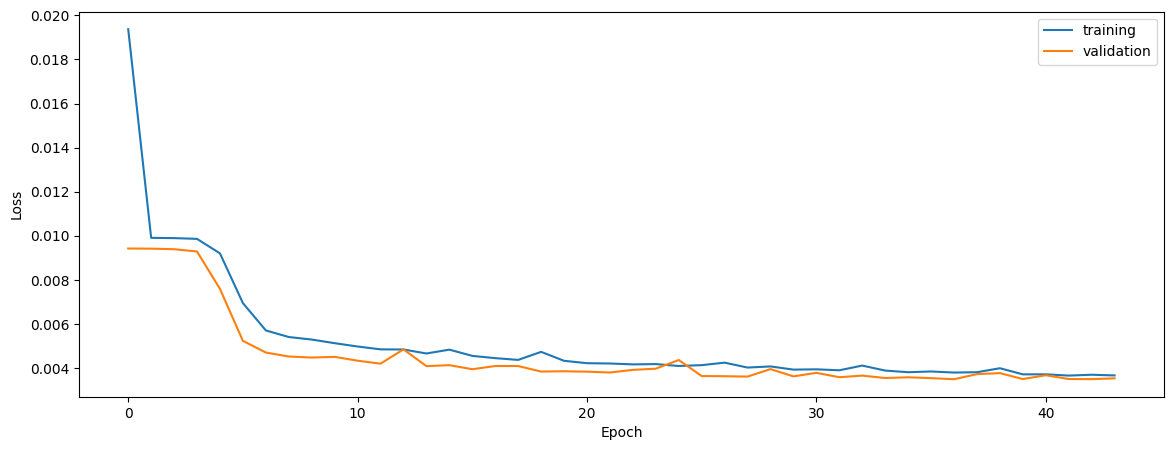

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.791121971969364
0.793059823371482
0.7602282097482986


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.791121971969364
0.793059823371482
0.7602282097482986


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7943718066735443
0.7958560345206737
0.7719388693771346


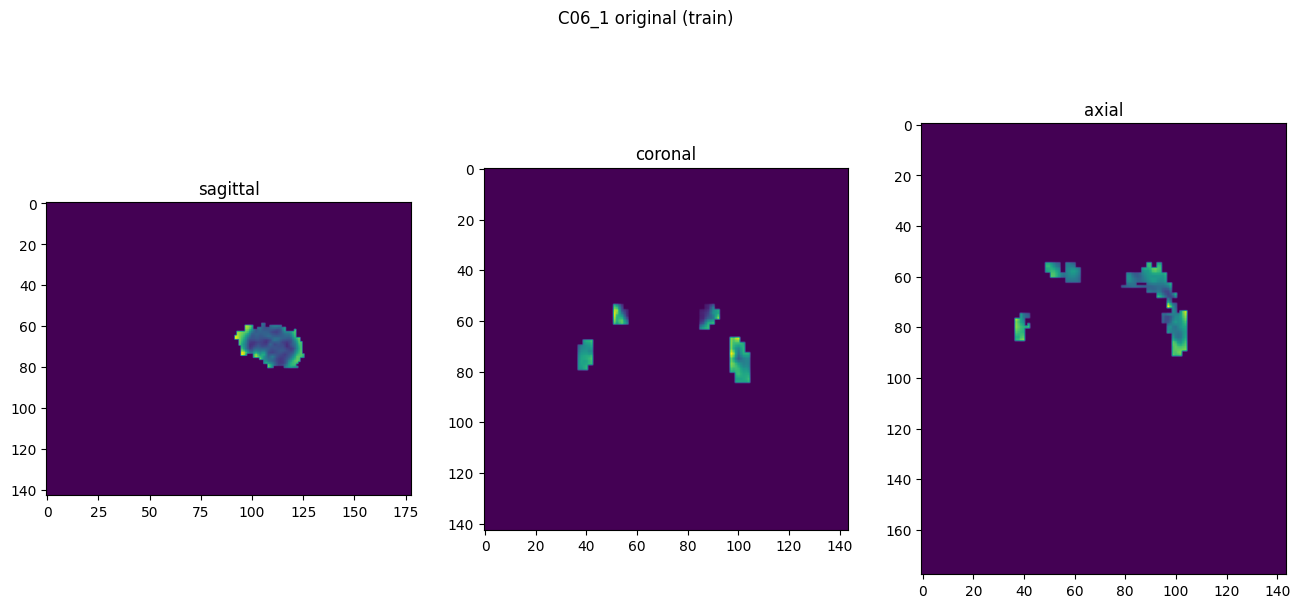

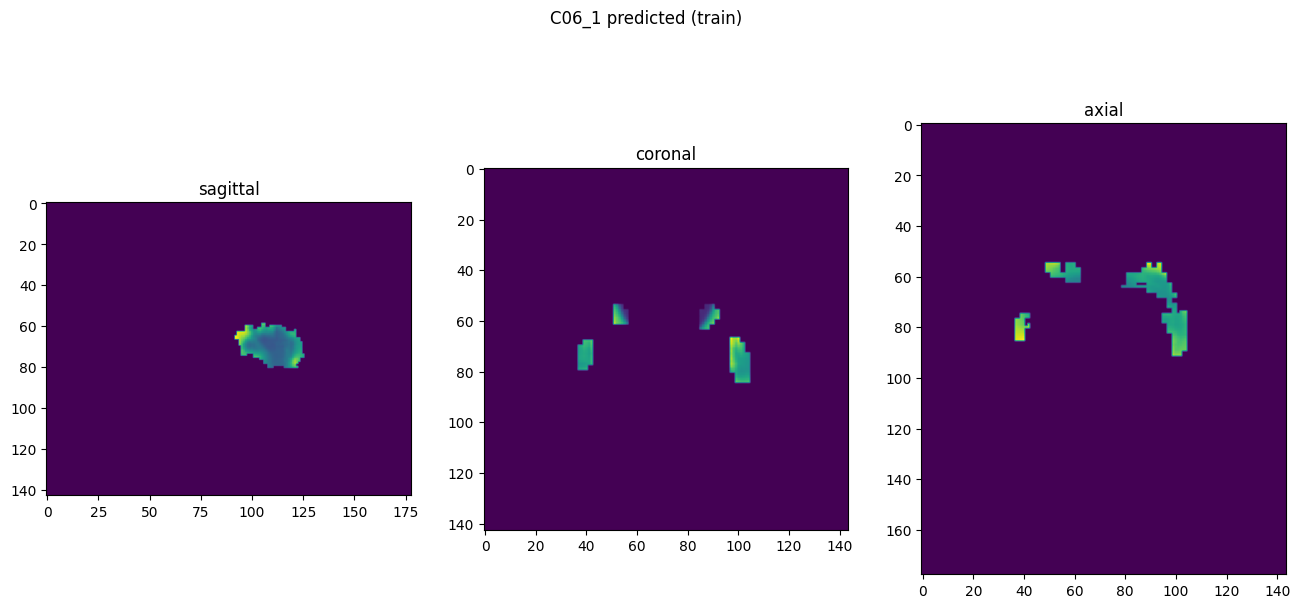

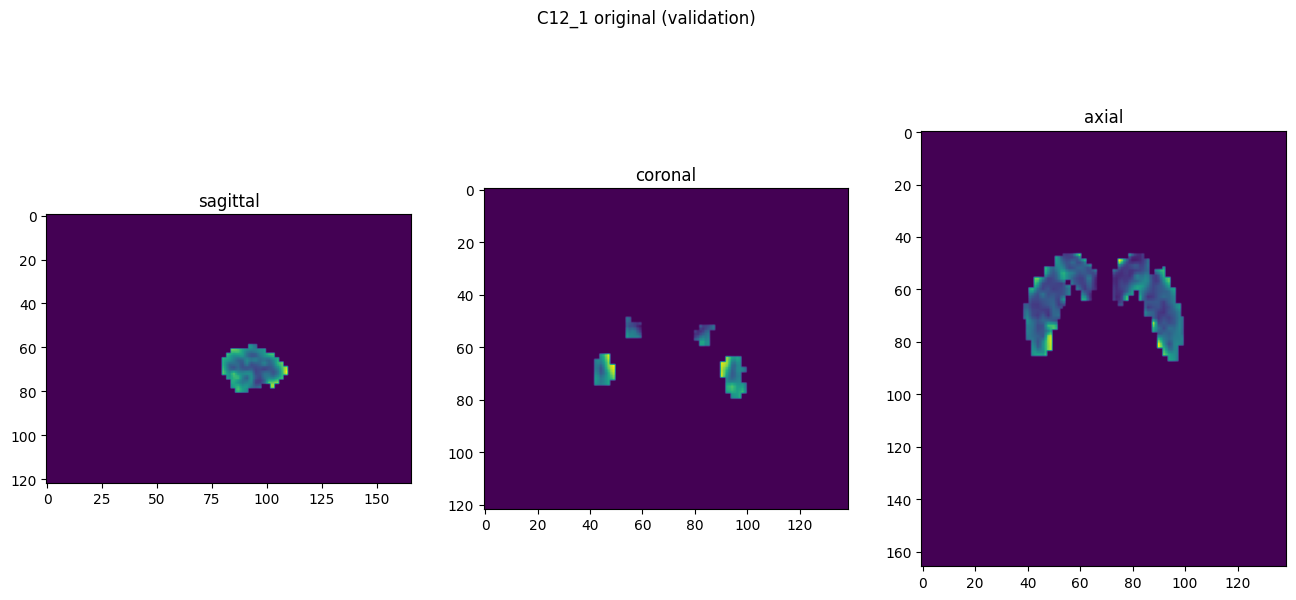

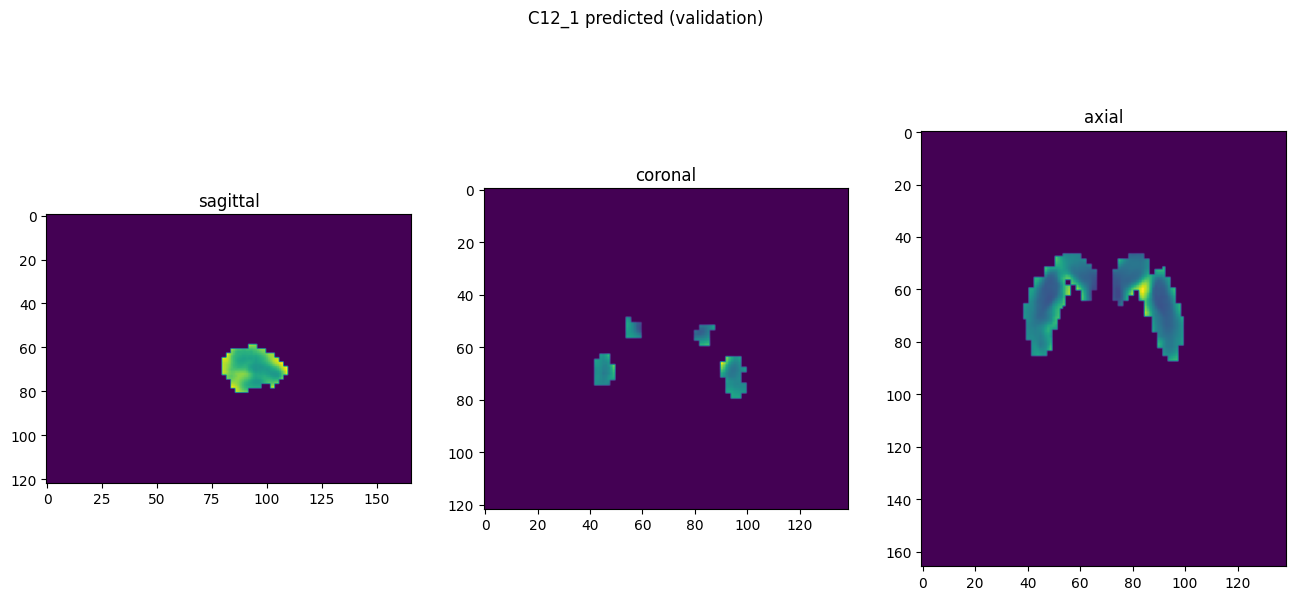

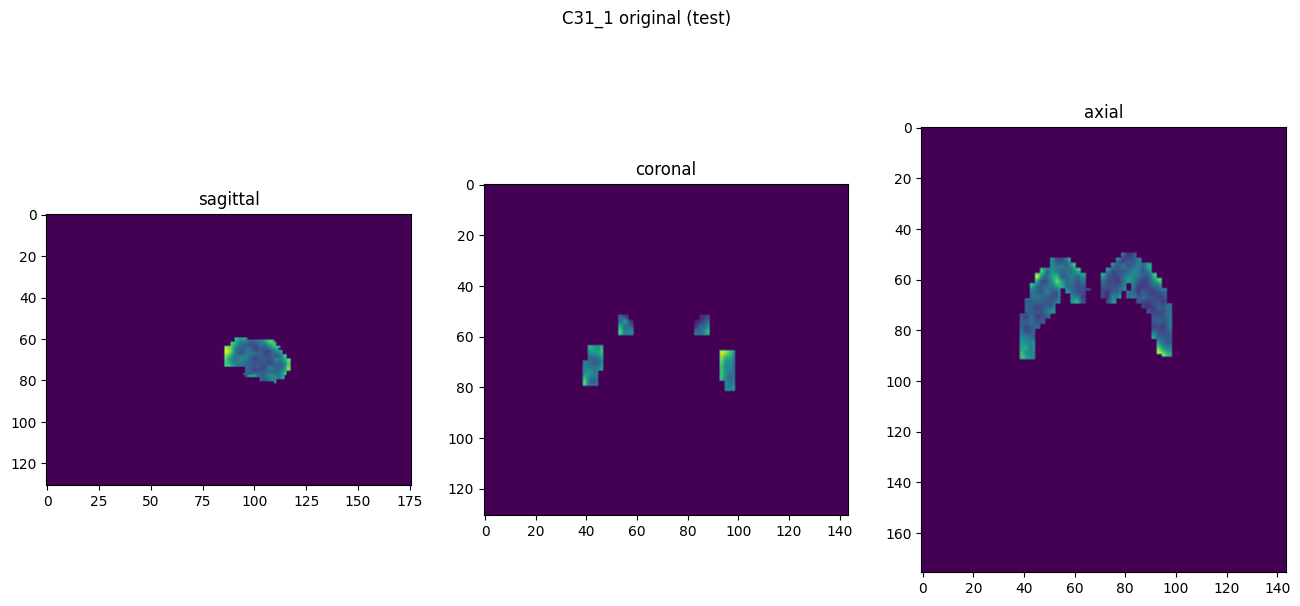

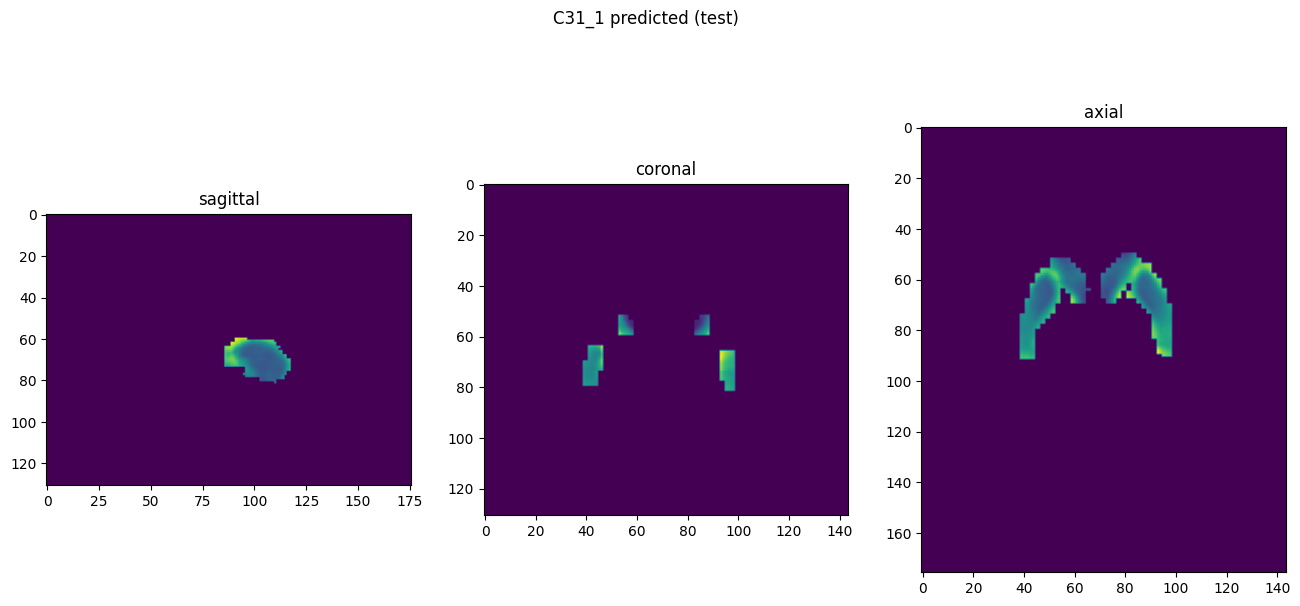

In [10]:
showResults(model, gen, threshold=None, background=False)